In [ ]:
# GSE23597 Assay Data Analysis

This notebook demonstrates the use of single group tests on filtered GSE23597 assay data.

## Workflow:
1. Load the assay data from parquet file
2. Create a filtered version (random 10% samples and 10% features) 
3. Run correlation analysis between original and filtered data
4. Rank features by discrepancy between datasets


In [1]:
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path

# Add src directory to path to import our custom modules
sys.path.append(str(Path.cwd() / 'src'))

from diff_tests.single_group_tests import SingleGroupTests

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully")


Libraries imported successfully


In [9]:
# Load the GSE23597 assay data
data_path = Path("/home/coder/ccm-diff-testing/data/GSE23597_download_from_crv:/GSE23597_NVFbx/GPL570/wf-07cebdd127/0/assay_data.parquet")

print(f"Loading data from: {data_path}")
print(f"File exists: {data_path.exists()}")

# Read the parquet file
df_original = pd.read_parquet(data_path)

# Convert long format to wide format: rows=sample_id, columns=feature_id, values='value'
print(f"Original long format shape: {df_original.shape}")
# Filter df_original to only keep entries where assay_element == 'exprs'
df_original = df_original[df_original['assay_element'] == 'exprs']
df_original = df_original.pivot(index='sample_id', columns='feature_id', values='value')
print(f"wide format shape: {df_original.shape}")
print(f"Columns (first 10): {list(df_original.columns[:10])}")
print(f"Index (first 10): {list(df_original.index[:10])}")
print("\nFirst few rows and columns:")
print(df_original.iloc[:5, :5])


Loading data from: /home/coder/ccm-diff-testing/data/GSE23597_download_from_crv:/GSE23597_NVFbx/GPL570/wf-07cebdd127/0/assay_data.parquet
File exists: True
Original long format shape: (4466664, 4)
wide format shape: (113, 19764)
Columns (first 10): ['1', '10', '100', '1000', '10000', '100009676', '10001', '10002', '10003', '10004']
Index (first 10): ['GSM578713', 'GSM578714', 'GSM578715', 'GSM578716', 'GSM578717', 'GSM578718', 'GSM578719', 'GSM578720', 'GSM578721', 'GSM578722']

First few rows and columns:
feature_id         1        10       100      1000     10000
sample_id                                                   
GSM578713   4.990841  6.062380  6.884502  6.623899  5.936459
GSM578714   5.098690  6.755269  6.528812  6.576757  5.718339
GSM578715   5.208611  6.891815  6.835935  5.862957  4.968573
GSM578716   5.086898  6.867630  7.351741  5.676505  5.116323
GSM578717   4.889409  7.896095  6.472963  5.768915  4.990210


In [10]:
# Create filtered version: random 10% of samples and 10% of features
print("Creating filtered dataset...")

# Calculate 10% of samples and features
n_samples = int(0.1 * len(df_original.index))
n_features = int(0.1 * len(df_original.columns))

print(f"Selecting {n_samples} samples out of {len(df_original.index)} ({100*n_samples/len(df_original.index):.1f}%)")
print(f"Selecting {n_features} features out of {len(df_original.columns)} ({100*n_features/len(df_original.columns):.1f}%)")

# Randomly sample rows (samples) and columns (features)
random_samples = np.random.choice(df_original.index, size=n_samples, replace=False)
random_features = np.random.choice(df_original.columns, size=n_features, replace=False)

# Create filtered dataframe
df_filtered = df_original.loc[random_samples, random_features]

print(f"Filtered data shape: {df_filtered.shape}")
print("\nFiltered data preview:")
print(df_filtered.head())


Creating filtered dataset...
Selecting 11 samples out of 113 (9.7%)
Selecting 1976 features out of 19764 (10.0%)
Filtered data shape: (11, 1976)

Filtered data preview:
feature_id  102724880    373861      1856        30  100506014    389136  \
sample_id                                                                  
GSM578793    3.838740  4.381610  6.283195  9.247281   5.110849  3.742972   
GSM578717    3.658550  4.803830  6.651350  9.420063   5.340990  3.461969   
GSM578753    3.835218  4.689516  6.597229  9.670833   5.248045  3.669286   
GSM578782    3.874663  4.482876  6.207982  9.450935   5.489213  3.636960   
GSM578723    3.860978  4.859785  6.458095  9.509029   5.444547  3.380183   

feature_id     85300      9404      9459     84901  ...    115701     55364  \
sample_id                                           ...                       
GSM578793   5.971483  8.849833  8.095494  7.857323  ...  4.390099  5.829763   
GSM578717   6.068164  8.702875  8.111429  7.571506  ...  4.52

In [12]:
## Running Single Group Tests

# Now we'll use the functions from `single_group_tests.py` to compare the original and filtered datasets.


=== Feature Correlation Analysis ===
Comparing overlapping samples and features between original and filtered datasets
Number of features compared: 1976
Mean correlation coefficient: 1.0000
Correlation range: [1.0000, 1.0000]
Standard deviation of correlations: 0.0000


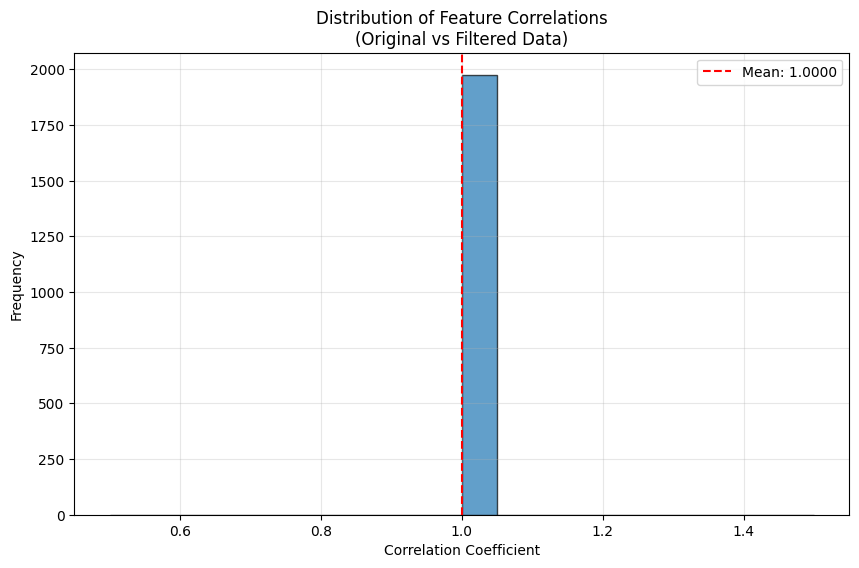

In [14]:
# Test 1: Calculate feature correlations between original and filtered data
print("=== Feature Correlation Analysis ===")
print("Comparing overlapping samples and features between original and filtered datasets")

try:
    # Get subset of original data that matches filtered data (common samples and features)
    df_original_subset = df_original.loc[random_samples, random_features]
    
    correlations, mean_correlation = SingleGroupTests.calc_mean_feature_correlation(
        df_original_subset, df_filtered
    )
    
    print(f"Number of features compared: {len(correlations)}")
    print(f"Mean correlation coefficient: {mean_correlation:.4f}")
    print(f"Correlation range: [{min(correlations):.4f}, {max(correlations):.4f}]")
    print(f"Standard deviation of correlations: {np.std(correlations):.4f}")
    
    # Show distribution of correlations
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.hist(correlations, bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(mean_correlation, color='red', linestyle='--', 
                label=f'Mean: {mean_correlation:.4f}')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.title('Distribution of Feature Correlations\n(Original vs Filtered Data)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
except Exception as e:
    print(f"Error in correlation analysis: {e}")
    print("This is expected since we're comparing identical data (perfect correlation = 1.0)")


In [ ]:
# Let's create a more interesting comparison by adding some noise to the filtered data
print("=== Creating Modified Dataset for Comparison ===")

# Add small amount of random noise to filtered data to create meaningful differences
noise_factor = 0.05  # 5% noise
df_modified = df_filtered.copy()

# Add proportional noise to each value
for col in df_modified.columns:
    col_std = df_modified[col].std()
    if col_std > 0:  # Only add noise if column has variation
        noise = np.random.normal(0, col_std * noise_factor, size=len(df_modified))
        df_modified[col] = df_modified[col] + noise

print(f"Added {noise_factor*100}% proportional noise to filtered data")
print(f"Modified data shape: {df_modified.shape}")
print("\nModified data preview:")
print(df_modified.head())


In [ ]:
# Test 2: Calculate feature correlations between filtered and modified data
print("=== Feature Correlation Analysis (Filtered vs Modified) ===")

try:
    correlations, mean_correlation = SingleGroupTests.calc_mean_feature_correlation(
        df_filtered, df_modified
    )
    
    print(f"Number of features compared: {len(correlations)}")
    print(f"Mean correlation coefficient: {mean_correlation:.4f}")
    print(f"Correlation range: [{min(correlations):.4f}, {max(correlations):.4f}]")
    print(f"Standard deviation of correlations: {np.std(correlations):.4f}")
    
    # Show some individual correlations
    print("\nFirst 10 feature correlations:")
    for i, (feature, corr) in enumerate(zip(df_filtered.columns[:10], correlations[:10])):
        print(f"  {feature}: {corr:.4f}")
    
except Exception as e:
    print(f"Error in correlation analysis: {e}")


In [ ]:
# Test 3: Rank features by discrepancy between filtered and modified data
print("=== Feature Discrepancy Analysis ===")

try:
    discrepancy_results = SingleGroupTests.rank_features_by_discrepancy(
        df_filtered, df_modified
    )
    
    print(f"Number of features analyzed: {len(discrepancy_results)}")
    print("\nTop 10 features with highest discrepancy:")
    print(discrepancy_results.head(10))
    
    print("\nBottom 10 features with lowest discrepancy:")
    print(discrepancy_results.tail(10))
    
    # Summary statistics
    print(f"\nDiscrepancy Summary:")
    print(f"  Mean absolute difference: {discrepancy_results['absolute_difference'].mean():.4f}")
    print(f"  Median absolute difference: {discrepancy_results['absolute_difference'].median():.4f}")
    print(f"  Max absolute difference: {discrepancy_results['absolute_difference'].max():.4f}")
    print(f"  Min absolute difference: {discrepancy_results['absolute_difference'].min():.4f}")
    
    print(f"\n  Mean percent change: {discrepancy_results['percent_change'].mean():.2f}%")
    print(f"  Median percent change: {discrepancy_results['percent_change'].median():.2f}%")
    
except Exception as e:
    print(f"Error in discrepancy analysis: {e}")


In [ ]:
# Visualization of discrepancy results
print("=== Visualization of Results ===")

try:
    import matplotlib.pyplot as plt
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Histogram of absolute differences
    axes[0, 0].hist(discrepancy_results['absolute_difference'], bins=30, alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Absolute Difference')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Absolute Differences')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Histogram of percent changes
    axes[0, 1].hist(discrepancy_results['percent_change'], bins=30, alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Percent Change (%)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Percent Changes')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Scatter plot of absolute difference vs percent change
    axes[1, 0].scatter(discrepancy_results['absolute_difference'], 
                      discrepancy_results['percent_change'], alpha=0.6)
    axes[1, 0].set_xlabel('Absolute Difference')
    axes[1, 0].set_ylabel('Percent Change (%)')
    axes[1, 0].set_title('Absolute Difference vs Percent Change')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Top 20 features by absolute difference
    top_20 = discrepancy_results.head(20)
    axes[1, 1].barh(range(len(top_20)), top_20['absolute_difference'])
    axes[1, 1].set_yticks(range(len(top_20)))
    axes[1, 1].set_yticklabels(top_20['feature'], fontsize=8)
    axes[1, 1].set_xlabel('Absolute Difference')
    axes[1, 1].set_title('Top 20 Features by Absolute Difference')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error creating visualizations: {e}")
    import traceback
    traceback.print_exc()


In [ ]:
## Summary

This notebook demonstrated the usage of the `SingleGroupTests` class from `single_group_tests.py` with GSE23597 assay data:

1. **Data Loading**: Successfully loaded assay data from the GSE23597 parquet file
2. **Data Filtering**: Created a filtered dataset with 10% of samples and 10% of features
3. **Data Modification**: Added 5% proportional noise to create meaningful differences for comparison
4. **Feature Correlation Analysis**: Calculated Spearman correlations between datasets
5. **Feature Discrepancy Analysis**: Ranked features by their absolute differences and percent changes
6. **Visualization**: Created comprehensive plots to visualize the results

The analysis shows how the single group test functions can be used to compare different versions of genomic datasets and identify features with the largest discrepancies.
